#### Smoke_dataset is a sample dataset made before Smog4000 dataset contains 400 images only
you can download smoke_dataset from this link below:
https://drive.google.com/file/d/1Psug8E25yfkF_fev_bTNu6tbJacSmF9E/view?usp=sharing

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import helper

In [2]:
data_dir = '/Documents/smoke_data'
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=40, shuffle=True)    

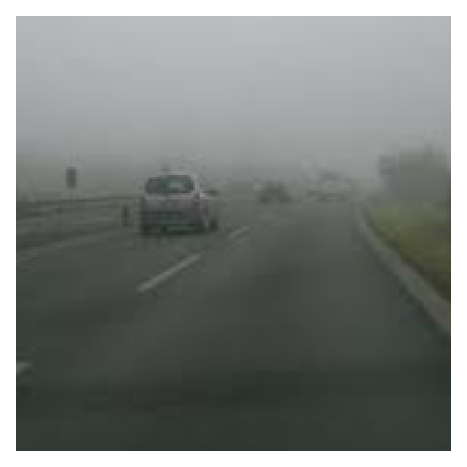

In [3]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

In [4]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 40
# percentage of training set to use as validation
valid_size = 0.2

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

In [6]:
print(len(train_data))
print(len(test_data))

360
40


In [7]:
num_train = len(train_data)
num_train

360

In [8]:
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('train_idx', len(train_idx))
print('valid_idx', len(valid_idx))

train_idx 288
valid_idx 72


In [9]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
print(len(train_sampler))
print(len(valid_sampler))

288
72


In [10]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)    
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

classes = ['clear','smog']

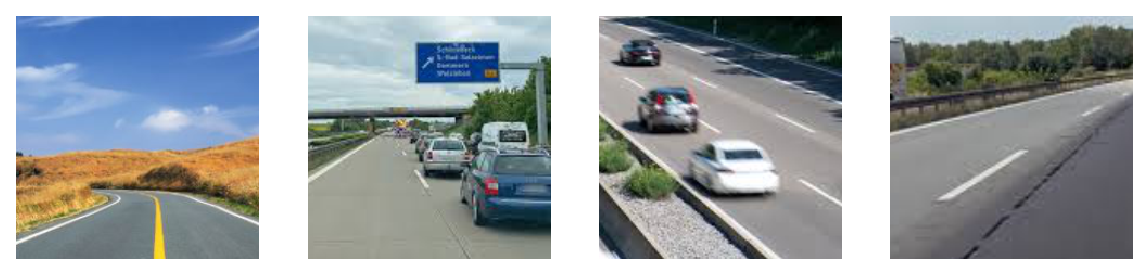

In [11]:
data_iter = iter(test_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 64, 7,stride=(2, 2), padding=3)
        self.norm0 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(64, 128, 5, stride=(2, 2), padding=2)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(128, 32, 3,padding=1)
        self.conv4 = nn.Conv2d(32, 32,3)
        # max pooling layer
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(32*3*3, 200)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(200, 40)
        self.fc3 = nn.Linear(40, 2)
        # dropout layer (p=0.25)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        #print(x.size())
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.norm0(x)
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = self.pool(F.relu(self.conv3(x)))
       # print(x.size())
        x = self.pool(F.relu(self.conv4(x)))
       # print(x.size())
        # flatten image input
        x = x.view(-1, 32*3*3)
       # print(x.size())
        # add dropout layer
        
        x = self.dropout(x)
       # print(x.size())
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        #print(x.size())
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
       # print(x.size())
        #x = x.view(196, -1)
        x = self.fc2(x)
       # print(x.size())
        x = self.dropout(x)
       # print(x.size())
        x = self.fc3(x)
       # print(x.size())
        return x

# create a complete CNN
model = Net()
print(model)
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
  (dropout): Dropout(p=0.25)
)
CUDA is available!  Training on GPU ...


In [13]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(32*3*3, 200)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(200, 40)),
                          ('fc3', nn.Linear(40, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model.classifier

Sequential(
  (fc1): Linear(in_features=288, out_features=200, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=200, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
  (output): LogSoftmax()
)

In [14]:
import torch.optim as optim
import time

In [15]:
for param in model.parameters():
    param.requires_grad = True
for device in ['cpu', 'cuda']:
   
    # specify loss function
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    

 
    
    model.to(device)

    for ii, (inputs, labels) in enumerate(train_loader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 0.424 seconds
Device = cuda; Time per batch: 0.006 seconds


In [16]:
for param in model.parameters():
    param.requires_grad = True
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'smoker.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.540903 	Validation Loss: 0.138774
Validation loss decreased (inf --> 0.138774).  Saving model ...
Epoch: 2 	Training Loss: 0.541104 	Validation Loss: 0.138119
Validation loss decreased (0.138774 --> 0.138119).  Saving model ...
Epoch: 3 	Training Loss: 0.531600 	Validation Loss: 0.136905
Validation loss decreased (0.138119 --> 0.136905).  Saving model ...
Epoch: 4 	Training Loss: 0.525546 	Validation Loss: 0.135377
Validation loss decreased (0.136905 --> 0.135377).  Saving model ...
Epoch: 5 	Training Loss: 0.510671 	Validation Loss: 0.131611
Validation loss decreased (0.135377 --> 0.131611).  Saving model ...
Epoch: 6 	Training Loss: 0.492402 	Validation Loss: 0.126224
Validation loss decreased (0.131611 --> 0.126224).  Saving model ...
Epoch: 7 	Training Loss: 0.468602 	Validation Loss: 0.119314
Validation loss decreased (0.126224 --> 0.119314).  Saving model ...
Epoch: 8 	Training Loss: 0.445078 	Validation Loss: 0.109485
Validation loss decreased (0.11931

In [18]:
model.load_state_dict(torch.load('smoker.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

#print(len(class_correct))
#print(len(class_total))

model.eval()

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)   
    #print(pred)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(40):
        
        label = target.data[i]
        
        class_correct[label] += correct[i].item()
        #print(correct[i].item())
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.032090

Test Accuracy of clear: 100% (20/20)
Test Accuracy of  smog: 100% (20/20)

Test Accuracy (Overall): 100% (40/40)
